In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import genesis as gs
# show the iamge
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


[I 04/26/25 16:57:42.542 484462] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [12]:
import random
import pathlib as pl
import numpy as np
import os, sys
import torch

USE_EEF = False
FINGERTIP_POS = -0.9
KINOVA_START_DOFS_POS = [0.3268500269015339, -1.4471734542578538, 2.3453266624159497, -1.3502152158191212, 2.209384006676201, -1.5125125137062945, -1, 1, FINGERTIP_POS, FINGERTIP_POS]


In [4]:
gs.init(backend=gs.gpu, seed=random.randint(0, 2**30), precision="32", logging_level="warning")

In [5]:
scene = gs.Scene(
            show_viewer=True,
        )

# path to current notebook
nb_path = os.path.abspath('nb.ipynb')
nb_path = pl.Path(nb_path)

kinova = scene.add_entity(
            gs.morphs.URDF(
                file=str(nb_path.parent / 'gen3_lite_2f_robotiq_85.urdf'),
                # file=str(pl.Path(__file__).parent / 'gen3_lite_2f_robotiq_85_with_camera.urdf'),
                fixed=True,
                convexify=True,
                pos=(0.0, 0.0, 0.055), # raise to account for table mount
            ),
            material=gs.materials.Rigid(friction=1.0),
            vis_mode="visual"

            # gs.morphs.MJCF(file="/home/j/workspace/genesis_pickaplace/005_tomato_soup_can/google_512k/kinbody.xml"),
        )


cam_0 = scene.add_camera(
    fov=45,
    GUI=True,
)


scene.build()


from kinova import JOINT_NAMES as kinova_joint_names, EEF_NAME as kinova_eef_name, TRIALS_POSITION_0, TRIALS_POSITION_1, TRIALS_POSITION_2
kdofs_idx = kdofs_idx = [kinova.get_joint(name).dof_idx_local for name in kinova_joint_names]
kinova.set_dofs_kp(
    kp             = 3*np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]),
    dofs_idx_local = kdofs_idx,
)
kinova.set_dofs_position(np.array(KINOVA_START_DOFS_POS), kdofs_idx)
scene.step()

Joint 'right_finger_tip_joint' mimics 'right_finger_bottom_joint' with multiplier -0.676 and offset 0.149
Joint 'left_finger_bottom_joint' mimics 'right_finger_bottom_joint' with multiplier -1.0 and offset 0.0
Joint 'left_finger_tip_joint' mimics 'right_finger_bottom_joint' with multiplier -0.676 and offset 0.149


[W 04/26/25 16:57:51.795 484462] [frontend_ir.cpp:begin_frontend_struct_for_on_external_tensor@1694] ti.loop_config(serialize=True) does not have effect on the struct for. The execution order is not guaranteed.


[Genesis] [17:00:25] [WARNING] This property is deprecated and will be removed in future release. Please use 'dof_idx_local' instead.
[Genesis] [17:00:25] [WARNING] This property is deprecated and will be removed in future release. Please use 'dof_idx_local' instead.
[Genesis] [17:00:25] [WARNING] This property is deprecated and will be removed in future release. Please use 'dof_idx_local' instead.
[Genesis] [17:00:25] [WARNING] This property is deprecated and will be removed in future release. Please use 'dof_idx_local' instead.
[Genesis] [17:00:25] [WARNING] This property is deprecated and will be removed in future release. Please use 'dof_idx_local' instead.
[Genesis] [17:00:25] [WARNING] This property is deprecated and will be removed in future release. Please use 'dof_idx_local' instead.
[Genesis] [17:00:25] [WARNING] This property is deprecated and will be removed in future release. Please use 'dof_idx_local' instead.
[Genesis] [17:00:25] [WARNING] This property is deprecated and

torch.Size([3]) torch.Size([3])


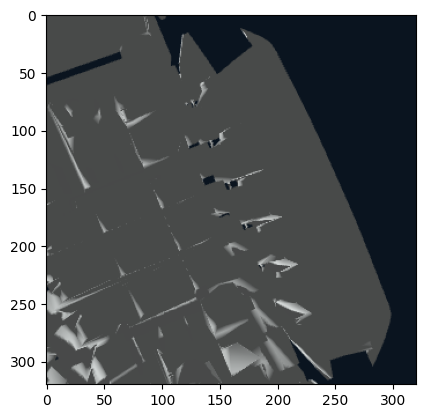

In [6]:
FINGERTIP_POS = -0.9
KINOVA_START_DOFS_POS = [0.3268500269015339, -1.4471734542578538, 2.3453266624159497, -1.3502152158191212, 2.209384006676201, -1.5125125137062945, -1, 1, FINGERTIP_POS, FINGERTIP_POS]
kinova.set_dofs_position(np.array(KINOVA_START_DOFS_POS), kdofs_idx)
scene.step()

def update_camera_position():
    wrist = kinova.get_link('end_effector_link')
    wrist_pos_offset = torch.Tensor([0.0, 0.0, 0.02]).to(device=wrist.get_pos().device)
    # Update the camera position based on the end effector position
    wrist_pos = wrist.get_pos()
    position = wrist.get_pos() + wrist_pos_offset
    rotation = wrist.get_ang()

    # get the mean position of the two fingertips
    left_fingertip = kinova.get_link('left_finger_dist_link')
    right_fingertip = kinova.get_link('right_finger_dist_link')
    middle = (left_fingertip.get_pos() + right_fingertip.get_pos()) / 2 + wrist_pos_offset

    # make a 4x4 transform out of the wrist position and rotation
    print(position.shape, rotation.shape)
    quat = gs.utils.geom.euler_to_quat(rotation)
    new_pos = gs.utils.geom.transform_by_quat(position, quat)


    cam_0.set_pose(pos=new_pos.cpu().numpy(), lookat=middle.cpu().numpy(), up=rotation.cpu().numpy())
    # cam_0.set_pose(pos=position.cpu().numpy(), lookat=middle.cpu().numpy(), up=(0, 0, 1))
update_camera_position()
img = cam_0.render(rgb=True, depth=False, segmentation=False, normal=False, use_imshow=False)[0]
imgplot = plt.imshow(img)

In [13]:
from genesis_sim2real.envs.demo_holder import GenesisDemoHolder
demo_holder = GenesisDemoHolder(use_eef=USE_EEF, subsample_ratio=2)


/home/james/workspace/genesis_sim2real/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/james/workspace/genesis_sim2real/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Loaded 96 demos from /home/james/workspace/genesis_sim2real/inthewild_trials
260 (880, 7) -- 250 (1675, 7) -- 290 (178, 7) -- 281 (520, 7) -- 309 (877, 7) -- 296 (1395, 7) -- 313 (747, 7) -- 266 (895, 7) -- 334 (572, 7) -- 252 (771, 7) -- 329 (709, 7) -- 298 (521, 7) -- 253 (597, 7) -- 299 (1306, 7) -- 335 (624, 7) -- 295 (3116, 7) -- 326 (483, 7) -- 304 (1040, 7) -- 278 (334, 7) -- 257 (504, 7) -- 236 (339, 7) -- 308 (677, 7) -- 234 (450, 7) -- 261 (706, 7) -- 282 (255, 7) -- 318 (759, 7) -- 286 (1876, 7) -- 284 (657, 7) -- 235 (442, 7) -- 269 (2428, 7) -- 244 (524, 7) -- 297 (569, 7) -- 333 (2035, 7) -- 307 (943, 7) -- 283 (660, 7) -- 301 (826, 7) -- 276 (730, 7) -- 316 (940, 7) -- 327 (687, 7) -- 245 (1662, 7) -- 233 (463, 7) -- 305 (631, 7) -- 321 (857, 7) -- 310 (917, 7) -- 328 (1383, 7) -- 254 (807, 7) -- 288 (1664, 7) -- 279 (1000, 7) -- 315 (1945, 7) -- 289 (301, 7) -- 302 (582, 7) -- 285 (418, 7) -- 246 (1311, 7) -- 242 (515, 7) -- 317 (723, 7) -- 239 (1378, 7) -- 240 (772, 7)

In [8]:

if '_eef' not in str(demo_holder.dir):
    genesis_arm = kinova
    output_dir='./inthewild_trials_eef'
    output_dir = pl.Path(output_dir)
    new_demos = []
    for idx, (trial_id, d) in enumerate(demo_holder.demos):
        # if trial_id != 235: continue
        new_d = []
        for i in range(d.shape[0]): # for each joint position action [j0, j1, j2, j3, j4, j5, gripper]
            joint_pos_theta = d[i, :6]
            joint_pos, joint_quat = genesis_arm.forward_kinematics(torch.tensor(joint_pos_theta))
            eef_pos = joint_pos[6].cpu().numpy(); eef_quat = joint_quat[6].cpu().numpy()
            eef_euler = gs.utils.geom.quat_to_xyz(eef_quat)
            
            action = np.concatenate((eef_pos, eef_euler, d[i, 6:]), axis=-1)
            # print(', '.join([f'{x:+.1f}' for x in action]), '||', ', '.join([f'{x:+.1f}' for x in d[i, :]]))
            new_d.append(action)

        # save the demo out
        output_path = output_dir / f'{trial_id}_episodes.npy'
        # make the new directory if it doesn't exist
        output_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(output_path, new_d)

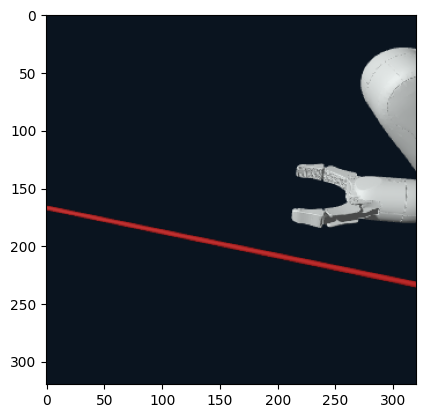

In [9]:
cam_0.set_pose(pos=(0.3, 0.6, 0.5), lookat=(0.5 ,0.0, 0.1), up=(0, 0, 1))
img = cam_0.render(rgb=True, depth=False, segmentation=False, normal=False, use_imshow=False)[0]
imgplot = plt.imshow(img)

In [10]:
# print out the link names
print([l.name for l in kinova._links])

['base_link', 'shoulder_link', 'arm_link', 'forearm_link', 'lower_wrist_link', 'upper_wrist_link', 'end_effector_link', 'right_finger_prox_link', 'left_finger_prox_link', 'right_finger_dist_link', 'left_finger_dist_link']


In [14]:

FINGERTIP_POS = -0.9

KINOVA_START_DOFS_POS = [0.3268500269015339, -1.4471734542578538, 2.3453266624159497, -1.3502152158191212, 2.209384006676201, -1.5125125137062945, -1, 1, FINGERTIP_POS, FINGERTIP_POS]
def reset_arm_pose():    
    kinova.set_dofs_position(np.array(KINOVA_START_DOFS_POS), kdofs_idx)
    scene.step()

# demo_holder.next_demo()
demo_holder.reset_current_demo()

Reset current demo 260


In [ ]:

print(f'{USE_EEF=}')
demo_holder.reset_current_demo()
from demo_holder import discrete_index_to_vector_map
reset_arm_pose()

from genesis.utils.geom import quat_to_xyz
next_joint_pos = demo_holder.next_action()['action']
eef_joint = kinova.get_link('end_effector_link')

current_eef_pos = kinova.get_link('end_effector_link').get_pos()
current_eef_euler = gs.utils.geom.quat_to_xyz(kinova.get_link('end_effector_link').get_quat())
# scene.clear_debug_objects()
# if next_joint_pos is not None:
DISCRETE_EEF = True
prev_eef_action = demo_holder.convert_single_joint_to_eef(kinova, next_joint_pos)
next_joint_pos = demo_holder.next_action()['action']
prev_discrete_action = None
idx = 0
while next_joint_pos is not None:
    # calculate the eef position given the eef joint position

    # if idx > 50: break
    if DISCRETE_EEF:
        eef_action = demo_holder.convert_single_joint_to_eef(kinova, next_joint_pos)
        d_eef_action = np.array(eef_action) - np.array(prev_eef_action); prev_eef_action = eef_action

        discrete_eef = demo_holder.convert_single_eef_to_discrete(kinova, d_eef_action, prev_discrete_action); prev_discrete_action = discrete_eef
        
        d_eef_vector = discrete_index_to_vector_map[discrete_eef]
        d_eef_pos, gripper_pos = d_eef_vector[:3], d_eef_vector[3:]

        print(', '.join(f'{x - y:+.3f}' for x,y in zip(d_eef_vector[:3], d_eef_action)))

        current_eef_quat = kinova.get_link('end_effector_link').get_quat()
        current_eef_pos = kinova.get_link('end_effector_link').get_pos()

        eef_pos = np.array(current_eef_pos.cpu().numpy()) + np.array(d_eef_pos)
        eef_quat = gs.utils.geom.xyz_to_quat(np.array([90., 90., 180.]))
        ik_joints = kinova.inverse_kinematics(kinova.get_link('end_effector_link'), pos=eef_pos, quat=eef_quat, rot_mask=[True, True, True])
        # ik_joints = kinova.inverse_kinematics(kinova.get_link('end_effector_link'), pos=eef_action[:3], quat=eef_quat, rot_mask=[True, True, True])

        
        # print the differences between the action and the d_eef
        cmd = ik_joints[:-4]

    elif USE_EEF:
        eef_pos, eef_euler, gripper_pos = next_joint_pos[:3], next_joint_pos[3:6], next_joint_pos[6:]

        deef_pos = np.array(eef_pos) - current_eef_pos.cpu().numpy()
        deef_euler = eef_euler - current_eef_euler.cpu().numpy()


        # get current end effector euler
        eef_link = kinova.get_link('end_effector_link')
        curr_eef_euler = gs.utils.geom.quat_to_xyz(eef_link.get_quat()).cpu().numpy()

        eef_action = np.concatenate((eef_pos, eef_euler, gripper_pos), axis=-1)
        # convert euler to quat


        # eef_quat = gs.utils.geom.xyz_to_quat(np.array([eef_euler[0], curr_eef_euler[1], curr_eef_euler[2]]))
        # eef_quat = gs.utils.geom.xyz_to_quat(np.array([curr_eef_euler[0], eef_euler[1], curr_eef_euler[2]]))
        # eef_quat = gs.utils.geom.xyz_to_quat(np.array([curr_eef_euler[0], curr_eef_euler[1], eef_euler[2]]))
        eef_quat = gs.utils.geom.xyz_to_quat(eef_euler)
        # print(', '.join(f'{x:+.1f}' for x in eef_euler))

        # get the joint positions that correspond to the new wrist position
        ik_joints = kinova.inverse_kinematics(eef_link, pos=eef_pos, quat=eef_quat, rot_mask=[False, False, True])
        
        print(', '.join(f'{x:+.1f}' for x in eef_action), '||', ', '.join(f'{x:+.1f}' for x in ik_joints))
        cmd = ik_joints[:-4]
    else:
        arm_pos, gripper_pos = next_joint_pos[:6], next_joint_pos[6:]
        # print(', '.join(f'{x:+.2f}' for x in arm_pos), ' gripper ', ', '.join(f'{x:.1f}' for x in gripper_pos))

        # get the current joint positions
        current_joint_pos = kinova.get_dofs_position(kdofs_idx)
        # print(', '.join(f'{x:+.2f}' for x in current_joint_pos))

        d = np.linalg.norm(np.array(arm_pos) - current_joint_pos[:-4].cpu().numpy())
        # print(f'---{d=:.2f}---')

        cmd = arm_pos # Use the arm position command directly
        if True: # from the arm position, calculate the eef_position, then convert that back to joint angles to test eef control
            joint_pos, joint_quat = kinova.forward_kinematics(torch.tensor(next_joint_pos))
            
            eef_pos, eef_quat = joint_pos[6], joint_quat[6]

            # convert quat to euler
            eef_xyz = quat_to_xyz(eef_quat.cpu().numpy())
            eef_quat = gs.utils.geom.xyz_to_quat(eef_xyz)

            tmp = np.concatenate((eef_pos.cpu().numpy(), eef_xyz, gripper_pos))

            # for pos in joint_pos:
            #     scene.draw_debug_sphere(pos, 0.01, color=(1, 0, 0))

            eef_action = np.concatenate((eef_pos.cpu().numpy(), eef_xyz, gripper_pos), axis=-1)

            ik_joints = kinova.inverse_kinematics(kinova.get_link('end_effector_link'), pos=eef_pos, quat=eef_quat, rot_mask=[True, True, True])
            print(', '.join(f'{x:+.1f}' for x in eef_action), '||', ', '.join(f'{x:+.1f}' for x in ik_joints))
            
            cmd = ik_joints[:-4]

    if DISCRETE_EEF:
        kinova.set_dofs_position(cmd, kdofs_idx[:-4])
    else:
        kinova.control_dofs_position(cmd, kdofs_idx[:-4])

    # update_camera_position()
    scene.step()
    
    current_eef_pos = kinova.get_link('end_effector_link').get_pos()
    current_eef_euler = gs.utils.geom.quat_to_xyz(kinova.get_link('end_effector_link').get_quat())

    # display the image
    # img = cam_0.render(rgb=True, depth=False, segmentation=False, normal=False, use_imshow=False)[0]
    # imgplot = plt.imshow(img)
    # plt.show(block=False)

    next_joint_pos = demo_holder.next_action()
    next_joint_pos = next_joint_pos['action'] if next_joint_pos is not None else None
    idx += 1
else:
    print(f'No more actions')




USE_EEF=False
Reset current demo 260
-0.000, +0.000, +0.000
+0.000, +0.000, -0.000
-0.000, -0.000, +0.000
-0.000, +0.000, -0.000
+0.000, -0.000, -0.000
-0.000, -0.000, +0.000
+0.000, +0.000, -0.000
+0.000, +0.000, -0.000
+0.000, +0.000, +0.000
+0.000, +0.000, -0.000
-0.000, -0.000, -0.000
-0.000, -0.000, -0.000
-0.000, -0.000, +0.000
+0.000, +0.000, -0.000
+0.000, +0.000, +0.000
-0.000, -0.000, -0.000
-0.000, -0.000, +0.000
-0.000, -0.000, -0.000
+0.000, +0.000, -0.000
-0.000, -0.000, +0.000
+0.000, -0.000, +0.000
+0.000, +0.000, +0.000
-0.000, -0.000, -0.000
-0.000, -0.000, -0.000
+0.000, +0.000, +0.000
-0.000, -0.000, +0.000
-0.000, +0.000, +0.000
-0.000, +0.000, +0.000
+0.000, -0.000, -0.000
-0.000, +0.000, +0.000
-0.000, -0.000, -0.000
+0.000, -0.000, -0.000
-0.000, -0.000, +0.000
+0.000, +0.000, -0.000
-0.000, -0.000, +0.000
+0.000, +0.000, -0.000
+0.000, +0.000, +0.000
+0.000, -0.000, -0.000
+0.000, +0.000, -0.000
-0.000, +0.000, +0.000
-0.000, -0.000, +0.000
-0.000, +0.000, -0.0

In [ ]:
demo_holder = GenesisDemoHolder(use_eef=USE_EEF, subsample_ratio=2)

demo_holder.reset_current_demo()
diff_eef_demo = demo_holder.convert_eef_to_diff_eef()
reset_arm_pose()
for _ in range(100):
    kinova.control_dofs_position(np.array(KINOVA_START_DOFS_POS), kdofs_idx)
    scene.step()


In [ ]:
scene.clear_debug_objects()
reset_arm_pose()

target_eef_pos, target_eef_quat = kinova.forward_kinematics(torch.tensor(KINOVA_START_DOFS_POS))
target_eef_euler = gs.utils.geom.quat_to_xyz(target_eef_quat[6]).cpu().numpy()
target_eef_pos = target_eef_pos[6].cpu().numpy()

eef_link = kinova.get_link('end_effector_link')
target_eef_pos = eef_link.get_pos().cpu().numpy()
target_eef_euler = gs.utils.geom.quat_to_xyz(eef_link.get_quat()).cpu().numpy()

# make a debug sphere at the target eef position
# scene.draw_debug_sphere(target_eef_pos, 0.01, color=(1, 0, 0))
# scene.draw_debug_sphere(eef_pos, 0.01, color=(0, 1, 0))
# scene.draw_debug_sphere(demo_holder.demos[demo_holder.idx][1][0, :3], 0.05, color=(0, 0, 1))



for idx, daction in enumerate(diff_eef_demo):
    print(f'{idx=}: ', end=' ')
    print(', '.join(f'{x:+.5f}' for x in daction))

    # get the current end effector pose
    eef_link = kinova.get_link('end_effector_link')


    prev_original = demo_holder.demos[demo_holder.idx][1][idx]
    original = demo_holder.demos[demo_holder.idx][1][idx+1]
    recalc_diff = original - prev_original

    # for o, t in zip(prev_original, np.concatenate((target_eef_pos, target_eef_euler))):
    #     print(f'\t{o:+.2f} --> {t:+.2f}')

    # print the difference between the original demo and the diff_eef
    # print(f'recalc diff {np.linalg.norm(daction - recalc_diff):.10f}. arm pose diff {np.linalg.norm(prev_original[:6] - np.concatenate((target_eef_pos, target_eef_euler))):.10f}')

    # get the new end effector pose

    target_eef_pos = target_eef_pos + daction[:3] #[0.0, 0.0, 0.0]
    scene.draw_debug_sphere(target_eef_pos, 0.01, color=(1, 0, 0))
    # new_eef_pos = curr_eef_pos + daction[:3]
    # print out the old and new eef positions
    # print('POS: ', ', '.join(f'{x:+.5f}' for x in curr_eef_pos), ' --> ', ', '.join(f'{x:+.5f}' for x in new_eef_pos))

    target_eef_euler = target_eef_euler + daction[3:6]
    # new_eef_euler = curr_eef_euler + daction[3:6]
    # print('EULER: ', ', '.join(f'{x:+.5f}' for x in curr_eef_euler), ' --> ', ', '.join(f'{x:+.5f}' for x in new_eef_euler))

    # what's the differnece between the original demo and the original demo + diff_eef?
    # print('POS DIFF: ', np.linalg.norm(original[:3] - target_eef_pos), ' EULER DIFF: ', np.linalg.norm(original[3:6] - target_eef_euler))

    target_eef_quat = gs.utils.geom.xyz_to_quat(target_eef_euler)

    # get the joint positions that correspond to the new wrist position
    ik_joints = kinova.inverse_kinematics(eef_link, pos=target_eef_pos, quat=target_eef_quat, rot_mask=[True, True, True])
    # ik_joints = kinova.inverse_kinematics(eef_link, pos=curr_eef_pos, quat=curr_eef_euler, rot_mask=[True, True, True])

    
    # print out the new joint positions
    # print(', '.join(f'{x:+.5f}' for x in ik_joints))

    kinova.control_dofs_position(ik_joints[:-4], kdofs_idx[:-4])
    # kinova.control_dofs_position(KINOVA_START_DOFS_POS, kdofs_idx)

    # for _ in range(10):
    scene.step()
    curr_eef_euler = gs.utils.geom.quat_to_xyz(eef_link.get_quat()).cpu().numpy()
    curr_eef_pos = eef_link.get_pos().cpu().numpy()
    if idx > 150: break


In [ ]:

# plot the differential eef actions. One plot for each axis
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

daction = diff_eef_demo[0]
fig, axs = plt.subplots(len(daction), 1, figsize=(10, 10), sharex=True)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Differential EEF Actions', fontsize=16)

for i in range(len(daction)):
    # plot the i-th action
    axs[i].plot(diff_eef_demo[:, i], label=f'Action {i+1}')
    axs[i].set_ylabel(f'Action {i+1}')
    axs[i].legend()
    axs[i].grid()
    if i < 3:
        axs[i].set_ylim(-0.01, 0.01)
    if i < 6:
        axs[i].set_ylim(-0.05, 0.05)
    else:
        axs[i].set_ylim(-20, 100)
    axs[i].set_xlim(0, len(diff_eef_demo))
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(10))

    # on the twincx axis, plot the cumulative sum of the differential actions
    axs[i].twinx().plot(np.cumsum(diff_eef_demo[:, i]), label=f'Cumulative Action {i+1}', color='g')

    # on the twinx axis, plot the original demo
    axs[i].twinx().plot(demo_holder.demos[0][1][:, i], label=f'Original Action {i+1}', color='r', alpha=0.5, linestyle='--')

    # axs[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
